### 🤖 Fine-Tuned T5 Model for LeetCode-Style Question Title Generation:
- **Models Tested**: <br>

  &nbsp;&nbsp;&nbsp;&nbsp;1. `facebook/bart-large-cnn`  
  &nbsp;&nbsp;&nbsp;&nbsp;2. `google/flan-t5-large`  
  &nbsp;&nbsp;&nbsp;&nbsp;3. `google/pegasus-cnn-xsum`

- **Goal**: Utilize a <u>pretrained model</u> to generate concise, descriptive titles, for questions from the `greengerong/leetcode` dataset that <u>mimics LeetCode's style and syntax for question titles</u> based solely on provided question input (not the solution).
- **Input**: <u>Detailed question statements</u> from `greengerong/leetcode` dataset.
- **Output**: <u>Descriptive LeetCode-style question titles</u> with their associated ids saved to `question_titles.json` in the following
  format:  <br>
  &nbsp;&nbsp;&nbsp;&nbsp;{  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"question_id" : 1,  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"reference_title" : "original_question"  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"generated_title" : "generated_question"  
  &nbsp;&nbsp;&nbsp;&nbsp;}  <br>

- **Finetuning**: The <u>highest performing model</u> judged by ROUGE-1, ROUGE-2, and ROUGE-L scores will be the <u>only model fine-tuned</u> using the `greengerong/leetcode` dataset due to (add explanation about hardware constraints) to hopefully further improve model performance.

### 🔧 Step 1: Setup Environment

*   Prepare the environment by installing the necessary libraries and configuring CUDA settings for optimal PyTorch performance.



In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
%pip install transformers datasets rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c5fa19a6e6fa46e6df4091c6b4a74ca1b8750b2367ffceec83c8103f3501c53a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

### 📂 Step 2: Import Libraries


*   Imports essential libraries, including `torch` for hardware acceleration, and `transformers` for T5 model integration.



In [ ]:
# import necessary libraries
import json
import transformers
import torch

# Set device: Use 'cuda' if available, otherwise 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print the active device
print(f"Using device: {device}")

Using device: cuda


### 📥 Step 3: Load Dataset

*   Downloads and loads the LeetCode dataset for testing and fine-tuning the models.



In [ ]:
from datasets import load_dataset
from google.colab import files

# upload data from hugging face for finetuning
data = load_dataset("greengerong/leetcode")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

leetcode-train.jsonl:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2360 [00:00<?, ? examples/s]

### 🧠 Step 4: Load T5 Model and Tokenizer
- Load the `facebook/bart-large-cnn,` `google/flan-t5-large`, and `google/pegasus-cnn-xsum` and return to TensorFlow tensors.


In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, PegasusTokenizer, PegasusForConditionalGeneration

# load the BART model and tokenizer
bart_model_name = "facebook/bart-large-cnn"
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name).to(device)
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)

# load the Flan-T5 model and tokenizer
t5_model_name = "google/flan-t5-large"
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)

# load the pegasus model and tokenizer
pegasus_model_name = "google/pegasus-xsum"
pegasus_model = PegasusForConditionalGeneration.from_pretrained(pegasus_model_name).to(device)
pegasus_tokenizer = PegasusTokenizer.from_pretrained(pegasus_model_name)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### 📝 Step 5: Generate Titles


*   Defines `generate_titles` to create LeetCode-style titles based on question content from greengerong's LeetCode dataset on Hugging Face. A JSON

*   Function Outputs: A JSON file containing corresponding question IDs, reference titles, and generated titles.
<br><br>
  

### 📂 Step 6: Save Output File to JSON


*   Saves the `question_id`, `reference_title`, and `generated_title` to a structured JSON file for future analysis in the following format:   <br>
  &nbsp;&nbsp;&nbsp;&nbsp;{  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"question_id" : 1,  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"reference_title" : "original_question"  
  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"generated_title" : "generated_question"  
  &nbsp;&nbsp;&nbsp;&nbsp;}  <br>





In [ ]:
def generate_titles(model, tokenizer, max_length=15, min_length=5, num_beams=4):
  """
  Generate LeetCode-style question titles based on the content of every question reieved in the
  question_content.json file and output the generated titles to a json file as well.

  Args:
    formatted_questions: A json file containing key value pairs of question_id and question content. The AI model will use the question_content as input to generate Leet-Code style question titles.
    model (transformer.PreTrainedModel): the pre-trained model for question title generation.
    tokenizer (transformers.PreTrainedTokenizer): the tokenizer corresponding to the pre-trained model.
    max_length (int): the maximum length of the generated title.
    min_length (int): the minimum length of the generated title.
    num_beams (int): the number of beams for beam search.

  Returns:
    str: path to the output JSON file containing the generated titles.
  """

  dataset = load_dataset("greengerong/leetcode")["train"].select(range(500))

  output_data = []

  for example in dataset:
    question_id = example["id"]
    question_content = example["content"]
    reference_title = example["title"]

    question_prompt = f"Generate a LeetCode-style title for the following LeetCode question: {question_content}"

    try:
      input_ids = tokenizer.encode(
          question_prompt,
          return_tensors="pt",
          max_length=256,
          truncation = True,
          padding = "max_length"
      ).to(model.device)

      title_ids = model.generate(
          input_ids,
          max_length=max_length,
          min_length=min_length,
          num_beams=num_beams,
          early_stopping=True
      )

      generated_title = tokenizer.decode(title_ids[0], skip_special_tokens=True)

      output_data.append({
        "question_id": question_id,
        "reference_title": reference_title,
        "generated_title": generated_title
      })

    except Exception as e:
      print(f"Error processing question {question_id}: {e}")

  return output_data


# function to save output fata to JSON file.
def save_output_to_json(output_data, output_file):
  with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=4)

### Generate Titles with Logging

In [ ]:
## note eventually separate out code that was used to generate questions for FEquestions.
import logging

logging.basicConfig(
    level=logging.INFO, # can switch INFO to DEBUG for more detailed logs.
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)


def generate_titles_w_logging(model, tokenizer, max_length=15, min_length=5, num_beams=4):
  """
  Generate LeetCode-style question titles based on the content of every question reieved in the
  question_content.json file and output the generated titles to a json file as well.

  Args:
    formatted_questions: A json file containing key value pairs of question_id and question content. The AI model will use the question_content as input to generate Leet-Code style question titles.
    model (transformer.PreTrainedModel): the pre-trained model for question title generation.
    tokenizer (transformers.PreTrainedTokenizer): the tokenizer corresponding to the pre-trained model.
    max_length (int): the maximum length of the generated title.
    min_length (int): the minimum length of the generated title.
    num_beams (int): the number of beams for beam search.

  Returns:
    str: path to the output JSON file containing the generated titles.
  """

  dataset = load_dataset("greengerong/leetcode")["train"].select(range(500))
  total_questions = len(dataset)
  logging.info(f"Loaded dataset with {total_questions} questions.")

  output_data = []

  for example in dataset:
    question_id = example["id"]
    question_content = example["content"]
    reference_title = example["title"]

    question_prompt = f"Generate a LeetCode-style title for the following LeetCode question: {question_content}"

    try:
      current_idx = len(output_data) + 1
      logging.info(f"Processing question {current_idx}/{total_questions} (ID: {question_id})")

      input_ids = tokenizer.encode(
          question_prompt,
          return_tensors="pt",
          max_length=256,
          truncation = True,
          padding = "max_length"
      ).to(model.device)

      title_ids = model.generate(
          input_ids,
          max_length=max_length,
          min_length=min_length,
          num_beams=num_beams,
          early_stopping=True
      )

      generated_title = tokenizer.decode(title_ids[0], skip_special_tokens=True)

      output_data.append({
        "question_id": question_id,
        "reference_title": reference_title,
        "generated_title": generated_title
      })

      # log success of individual title
      logging.info(f"Successfully generated title for question {current_idx}/{total_questions} (ID: {question_id})")


    except Exception as e:
      print(f"Error processing question {question_id}: {e}")
      logging.error(f"Error processing question (ID: {question_id}): {e}")

  # log the successful finish of all titles
  logging.info("All titles generated successfully.")
  return output_data


# function to save output fata to JSON file.
def save_output_to_json(output_data, output_file):
  with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=4)


### 📊 Evaluate Models via ROUGE Metrics

*   Calculates precision, recall, and F1 score averages for ROUGE-1, ROUGE-2, and ROUGE-L metrics to evaluate the quality of generated titles vs. reference titles.




In [ ]:
from datasets import load_dataset
from transformers import PreTrainedTokenizer, PreTrainedModel
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

def calculate_rouge(output_data):
    """
    Calculate the f1-score, precision, and recall values of the ROUGE-1, ROUGE-2,
    and ROUGE-L metrics for the generated titles.

    Args:
        model (PreTrainedModel): The pre-trained model for question title generation.
        tokenizer (PreTrainedTokenizer): The tokenizer corresponding to the pre-trained model.
        max_length (int): The maximum length of the generated title.
        min_length (int): The minimum length of the generated title.
        num_beams (int): The number of beams for beam search.

    Returns:
        f1-score, precision, and recall for ROUGE-1, ROUGE-2, and ROUGE-L as floats.
    """

    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    total_scores = {"rouge1": {"fmeasure": 0.0, "precision": 0.0, "recall": 0.0},
                    "rouge2": {"fmeasure": 0.0, "precision": 0.0, "recall": 0.0},
                    "rougeL": {"fmeasure": 0.0, "precision": 0.0, "recall": 0.0}}

    count = len(output_data)

    for item in output_data:
        reference_title = item["reference_title"]
        generated_title = item["generated_title"]

        scores = scorer.score(reference_title, generated_title)

        total_scores["rouge1"]["fmeasure"] += scores["rouge1"].fmeasure
        total_scores["rouge1"]["precision"] += scores["rouge1"].precision
        total_scores["rouge1"]["recall"] += scores["rouge1"].recall

        total_scores["rouge2"]["fmeasure"] += scores["rouge2"].fmeasure
        total_scores["rouge2"]["precision"] += scores["rouge2"].precision
        total_scores["rouge2"]["recall"] += scores["rouge2"].recall

        total_scores["rougeL"]["fmeasure"] += scores["rougeL"].fmeasure
        total_scores["rougeL"]["precision"] += scores["rougeL"].precision
        total_scores["rougeL"]["recall"] += scores["rougeL"].recall

    avg_scores = {metric: {metric_type: score / count if count > 0 else 0.0 for metric_type, score in score_dict.items()} for metric, score_dict in total_scores.items()}

    return avg_scores


def write_rouge_to_file(avg_scores, filename="rouge_scores.txt"):
    """
    Writes the average ROUGE scores to a specified output file in a readable format.

    Args:
        avg_scores (dict): A dictionary containing the average f-measure, precision,
                           and recall values for each ROUGE metric.
        filename (str): The name of the output file (default: "rouge_scores.txt").
    """
    try:
        with open(filename, "w") as file:
            file.write("Average ROUGE Scores:\n")
            for metric, scores in avg_scores.items():
                file.write(f"\n{metric.upper()}:\n")
                for metric_type, value in scores.items():
                    file.write(f"  {metric_type.capitalize()}: {value:.4f}\n")
        print(f"ROUGE scores successfully written to {filename}")

    except Exception as e:
        print(f"An error occurred while writing to {filename}: {e}")


### 🔍 Visualization of ROUGE Metrics


*   The `plot_rouge_scores` function plots the average precision, recall, and F1 scores of the ROUGE metrics in a bar graph for easy visualization.




In [ ]:
def plot_rouge_scores(rouge_avg, filename, title_prefix=""):
  """
  Plot the f1-score, precision, and recall values of the ROUGE-1, ROUGE-2,
  and ROUGE-L metrics for the generated titles on a bar graph.

  Args:
    avg_scores (dict): A dictionary containing the average ROUGE scores for each metric.

  Returns:
    None
  """

  metrics = ["rouge1", "rouge2", "rougeL"]
  metric_types = ["precision", "recall", "fmeasure"]

  metric_values = {
        metric_type: [rouge_avg[metric][metric_type] for metric in metrics]
        for metric_type in metric_types
    }

  x = range(len(metrics))
  width = 0.25

  fig, ax = plt.subplots(figsize=(10, 6))
  ax.bar([i - width for i in x], metric_values["precision"], width, label="Precision")
  ax.bar(x, metric_values["recall"], width, label="Recall")
  ax.bar([i + width for i in x], metric_values["fmeasure"], width, label="F1-Score")

  title = f"{title_prefix} ROUGE Scores"

  ax.set_xlabel("ROUGE Metrics", fontsize=14)
  ax.set_ylabel("Scores", fontsize=14)
  ax.set_title(title, fontsize=16)
  ax.set_xticks(x)
  ax.set_xticklabels(["ROUGE-1", "ROUGE-2", "ROUGE-L"])
  ax.legend(loc="upper right")

  plt.ylim(0, 1)

  plt.grid(axis='y', linestyle='--', alpha=0.7)

  plt.savefig(filename, bbox_inches='tight')

  plt.show()

### 📝 Test the Models


*   Determines the highest performing model based on the ROUGE-1, ROUGE-2, and ROUGE-L results and compares the ROUGE graphs for easy analysis.



T5 output file generated successfully.

ROUGE scores successfully written to t5_rouge_scores.txt
ROUGE-1: {'fmeasure': 0.2559865301365306, 'precision': 0.2472988178488179, 'recall': 0.32232380952380946}, ROUGE-2: {'fmeasure': 0.11767176712176704, 'precision': 0.11362222222222226, 'recall': 0.1504047619047619}, ROUGE-L: {'fmeasure': 0.24727924297924345, 'precision': 0.2382336663336665, 'recall': 0.31215}



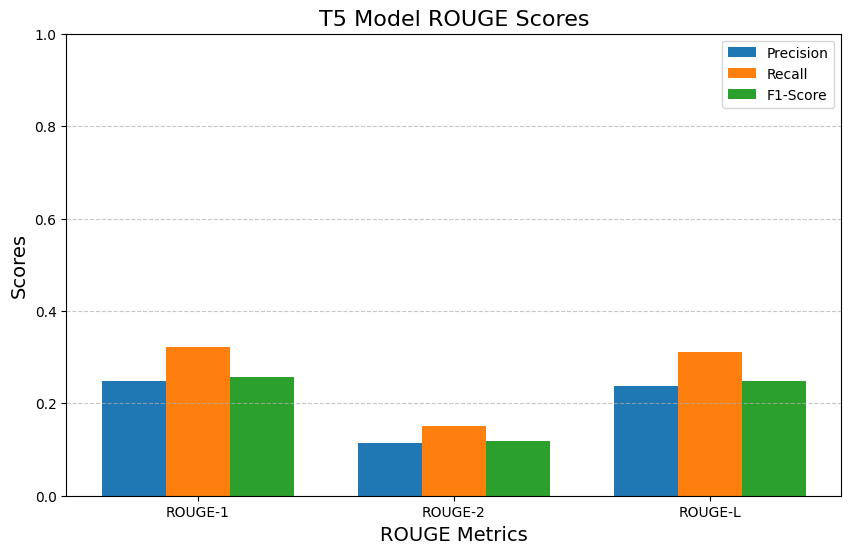

In [ ]:
bart_output_file = generate_titles(bart_model, bart_tokenizer)
# Save generated titles to a JSON file
save_output_to_json(bart_output_file, 'bart_generated_titles.json')
print(f"BART output file generated successfully.\n")

# calculate bart ROUGE scores based on dataset
bart_rouge_scores = calculate_rouge(bart_output_file)
write_rouge_to_file(bart_rouge_scores, filename="bart_rouge_scores.txt")
print(f"ROUGE-1: {bart_rouge_scores['rouge1']}, ROUGE-2: {bart_rouge_scores['rouge2']}, ROUGE-L: {bart_rouge_scores['rougeL']}\n")
plot_rouge_scores(bart_rouge_scores, 'bart_rouge_plots.png', title_prefix="Bart Model")


# generate t5 model question titles
t5_output_file = generate_titles(t5_model, t5_tokenizer)
# Save generated t5 titles to a JSON file
save_output_to_json(t5_output_file, 't5_generated_titles.json')
print(f"T5 output file generated successfully.\n")

# calculate t5 ROUGE scores based on dataset
t5_rouge_scores = calculate_rouge(t5_output_file)
write_rouge_to_file(t5_rouge_scores, filename="t5_rouge_scores.txt")
print(f"ROUGE-1: {t5_rouge_scores['rouge1']}, ROUGE-2: {t5_rouge_scores['rouge2']}, ROUGE-L: {t5_rouge_scores['rougeL']}\n")
plot_rouge_scores(t5_rouge_scores, 't5_rouge_plots.png', title_prefix="T5 Model")


# generate pegasus model question titles
pegasus_output_file = generate_titles(pegasus_model, pegasus_tokenizer)
# save generated pegasus titles to a JSON file
save_output_to_json(pegasus_output_file, 'pegasus_generated_titles.json')
print(f"pegasus output file generated successfully.\n")

# calculate pegasus ROUGE scores based on dataset
pegasus_rouge_scores = calculate_rouge(pegasus_output_file)
write_rouge_to_file(pegasus_rouge_scores, filename="pegasus_rouge_scores.txt")
#print(f"ROUGE-1: {pegasus_rouge_scores['rouge1']}, ROUGE-2: {pegasus_rouge_scores['rouge2']}, ROUGE-L: {pegasus_rouge_scores['rougeL']}\n")
plot_rouge_scores(pegasus_rouge_scores, 'pegasus_rouge_plots.png', title_prefix="Pegasus Model")

In [ ]:
from transformers import TrainerCallback

class TrainLossCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = None

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.train_loss = logs["loss"]

train_loss_callback = TrainLossCallback()

### 💾 Step 9: Fine-Tune T5 Model



*   The `fine_tune_t5` function optimizes the T5 model using the LeetCode dataset to improve performance for generating coding question titles.



In [ ]:
from datasets import load_dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

def fine_tune_t5(dataset_name="greengerong/leetcode", t5_model_name="google/flan-t5-large", output_dir="./fine_tuned_model"):
    """
    Fine-tunes a T5 model on a given dataset for sequence-to-sequence tasks.

    Args:
        dataset_name (str): The Hugging Face dataset to use for fine-tuning.
        model_name (str): The pre-trained T5 model to fine-tune.
        output_dir (str): Directory to save the fine-tuned model.

    Returns:
        dict: Evaluation metrics from the test dataset.
    """

    dataset = load_dataset("greengerong/leetcode")["train"]
    t5_tokenizer = AutoTokenizer.from_pretrained(t5_model_name)

    def tokenize_function(examples, max_input_length=256, max_target_length=64):
        inputs = [f"Generate a LeetCode-style question title based on the LeetCode-style prompt {content}" for content in examples["content"]]
        targets = examples["title"]

        model_inputs = t5_tokenizer(
            inputs,
            max_length=max_input_length,
            padding="max_length",
            truncation=True,
        )

        labels = t5_tokenizer(
            targets,
            max_length=max_target_length,
            padding="max_length",
            truncation=True,
        )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["content", "title", "id"],
    )

    dataset_split = tokenized_dataset.train_test_split(test_size=0.1)

    model = AutoModelForSeq2SeqLM.from_pretrained(t5_model_name)

    data_collator = DataCollatorForSeq2Seq(tokenizer=t5_tokenizer, model=model)

    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        run_name="fine_tuning_t5",
        eval_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=2,
        gradient_checkpointing=True,
        fp16=True,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=3,
        predict_with_generate=True,
        logging_dir="./logs",
        logging_steps=100,
        save_steps=500,
        save_strategy="steps",
        report_to="none",
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset_split["train"],
        eval_dataset=dataset_split["test"],
        data_collator=data_collator,
        callbacks=[train_loss_callback],
    )

    trainer.train()


    trainer.save_model(output_dir)
    t5_tokenizer.save_pretrained(output_dir)

    metrics = trainer.evaluate()
    return metrics


### 🔗 Step 10: Save Metrics and Model

*   Executes the fine-tuning process and saves the fine-tuned model, tokenizerm and evaluation metrics.




In [ ]:
metrics = fine_tune_t5(
    dataset_name="greengerong/leetcode",
    t5_model_name="google/flan-t5-large",
    output_dir="./fine_tuned_t5_model",
)

print("Evaluation Metrics:", metrics)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

leetcode-train.jsonl:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2360 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/2360 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,0.231500,0.188144
2,0.181800,0.182506


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.231500,0.188144
2,0.181800,0.182506
3,0.140400,0.185363


Evaluation Metrics: {'eval_loss': 0.1853628307580948, 'eval_runtime': 306.2416, 'eval_samples_per_second': 0.771, 'eval_steps_per_second': 0.385, 'epoch': 3.0}


### Step 11: Login to Hugging Face


*   Authenticates with Hugging Face using personal access token to enable model uploads and other API interactions.



In [ ]:
# upload to the hugging face space
from huggingface_hub import login
from dotenv import load_dotenv

load_dotenv()

token = os.getenv("HUGGING_FACE_TOKEN")

login(token=token)

### Step 12: Load the Fine-Tuned Model and Tokenizer


*   Loads the locally fine-tuned T5 model and tokenizer for subsequent operations, such as generating titles or uploading to the Hugging Face Hub.



In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# load fine-tuned T5 model and tokenizer
fine_tuned_model_dir = "./fine_tuned_t5_model"
fine_tuned_t5_model = AutoModelForSeq2SeqLM.from_pretrained(fine_tuned_model_dir)
fine_tuned_t5_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_model_dir)

# push the model and tokenizer to the Hugging Face Hub
fine_tuned_t5_model.push_to_hub("e4s70f3d3n/t5-leetcode-title-gen", private=True)
fine_tuned_t5_tokenizer.push_to_hub("e4s70f3d3n/t5-leetcode-title-gen", private=True)

print("Model successfully uploaded!")


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

Model successfully uploaded!


### Step 13: Reload Model from Hugging Face Hub (Optional)


*   Reloads the uploaded model from the Hugging Face Hub for use in a new or restarted runtime.



In [ ]:
# this cell is for when the runtime dies and I have to load my model from my HuggingFace space to access it
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# store the hugging face space in the variable name
t5_fined_tuned_model = "e4s70f3d3n/t5-leetcode-title-gen"

# load the model from the space into the model and tokenizer
fine_tuned_t5_model = AutoModelForSeq2SeqLM.from_pretrained(
    t5_fined_tuned_model,
    token=token
    )

fine_tuned_t5_tokenizer = AutoTokenizer.from_pretrained(
    t5_fined_tuned_model,
    token=token
    )

print("The t5-leetcode-title-gen model and tokenizer were successfully loaded from East0fEd3n's HuggingFace Space.")



config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

The t5-leetcode-title-gen model and tokenizer were successfully loaded from East0fEd3n's HuggingFace Space.


### Step 14: Generate Titles and Compute ROUGE Scores Based on Fine-Tuned Model


*   Uses the fine-tuned model to generate LeetCode-style titles for a dataset of coding problems.
*   Computes ROUGE-1, ROUGE-2, and ROUGE-L scores for the fine-tuned model, saving the results to a text file for detailed evaluation and ploting the precision, recall, and F1 scores for enhanced interpretability and presentation.



Starting the title generation process


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

leetcode-train.jsonl:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2360 [00:00<?, ? examples/s]

titles were successfully generated
saving titles to JSON file
Fine-tuned T5 JSON file generated and saved successfully.

calculating ROUGE scores for fine-tuned model
writing the ROUGE scores to .txt file
ROUGE scores successfully written to fine_tuned_t5_rouge_scores.txt
ROUGE scores successfully written to .txt file
ROUGE-1: {'fmeasure': 0.6416050469138713, 'precision': 0.6285310966810966, 'recall': 0.7094571428571431}
ROUGE-2: {'fmeasure': 0.45386137196137233, 'precision': 0.45536111111111105, 'recall': 0.4965547619047619}
ROUGE-L: {'fmeasure': 0.6234300052888299, 'precision': 0.6106588744588742, 'recall': 0.6878809523809526}

ploting graph of ROUGE scores for fine-tuned model


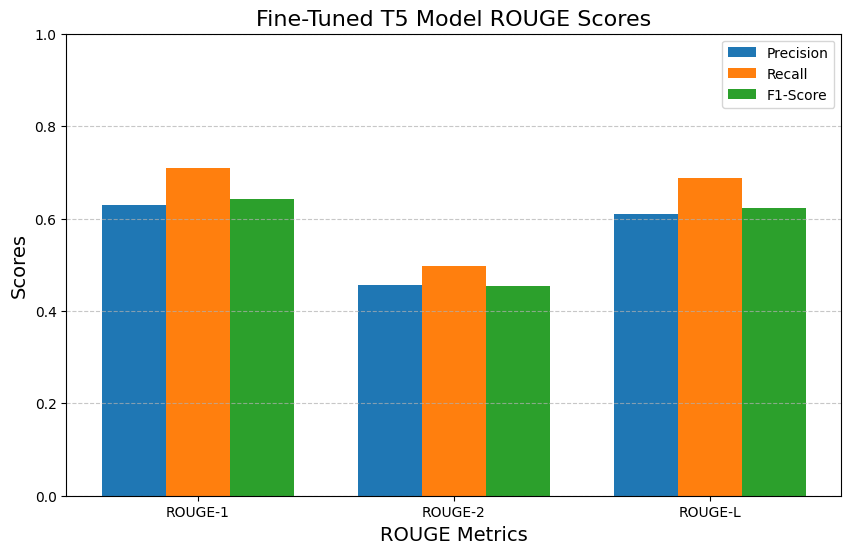

In [ ]:
print("Starting the title generation process")
# generate titles with the fine-tuned T5 model
fine_tuned_output_file = generate_titles_w_logging(fine_tuned_t5_model, fine_tuned_t5_tokenizer)
print("titles were successfully generated")


print("saving titles to JSON file")
# save the generated titles to a JSON file
save_output_to_json(fine_tuned_output_file, 'fine_tuned_t5_generated_titles.json')
print(f"Fine-tuned T5 JSON file generated and saved successfully.\n")


# calculate the ROUGE scores for the fine-tuned T5 model and write to output file
print("calculating ROUGE scores for fine-tuned model")
fine_tuned_t5_rouge_scores = calculate_rouge(fine_tuned_output_file)
print("writing the ROUGE scores to .txt file")
write_rouge_to_file(fine_tuned_t5_rouge_scores, filename="fine_tuned_t5_rouge_scores.txt")
print("ROUGE scores successfully written to .txt file")


# print the scores to the terminal for analysis as well
print(f"ROUGE-1: {fine_tuned_t5_rouge_scores['rouge1']}")
print(f"ROUGE-2: {fine_tuned_t5_rouge_scores['rouge2']}")
print(f"ROUGE-L: {fine_tuned_t5_rouge_scores['rougeL']}\n")


# generate the graph for the fine-tuned model
print("ploting graph of ROUGE scores for fine-tuned model")
plot_rouge_scores(fine_tuned_t5_rouge_scores, 'fine_tuned_t5_rouge_plots.png', title_prefix="Fine-Tuned T5 Model")


### 🎉 Final Output



*   Generated Titles: Saved to `fine_tuned_t5_generated_titles.json`.
*   Evaluation Metrics: Detailed ROUGE scores stored in `fine_tuned_t5_rouge_scores.txt`.
*   Visualization: ROUGE score plots saved as `fine_tuned_t5_rouge_plots.png`.

